# Load the data

In [214]:
%matplotlib inline
import pandas as pd

file_path = 'VOO_15years.csv'
# Use pandas to read the CSV file into a DataFrame
df = pd.read_csv(file_path)
print(df.head())

         Date        Open        High         Low       Close  Adj Close  \
0  2010-09-09  102.500000  102.500000  101.139999  101.320000  78.743355   
1  2010-09-10  101.680000  101.860001  101.300003  101.779999  79.100868   
2  2010-09-13  102.959999  103.139999  102.500000  103.059998  80.095642   
3  2010-09-14  102.839996  103.480003  102.379997  103.040001  80.080093   
4  2010-09-15  102.620003  103.379997  102.400002  103.300003  80.282173   

   Volume  
0   26500  
1    8600  
2   33750  
3   59400  
4    9250  


# Add technical indicators

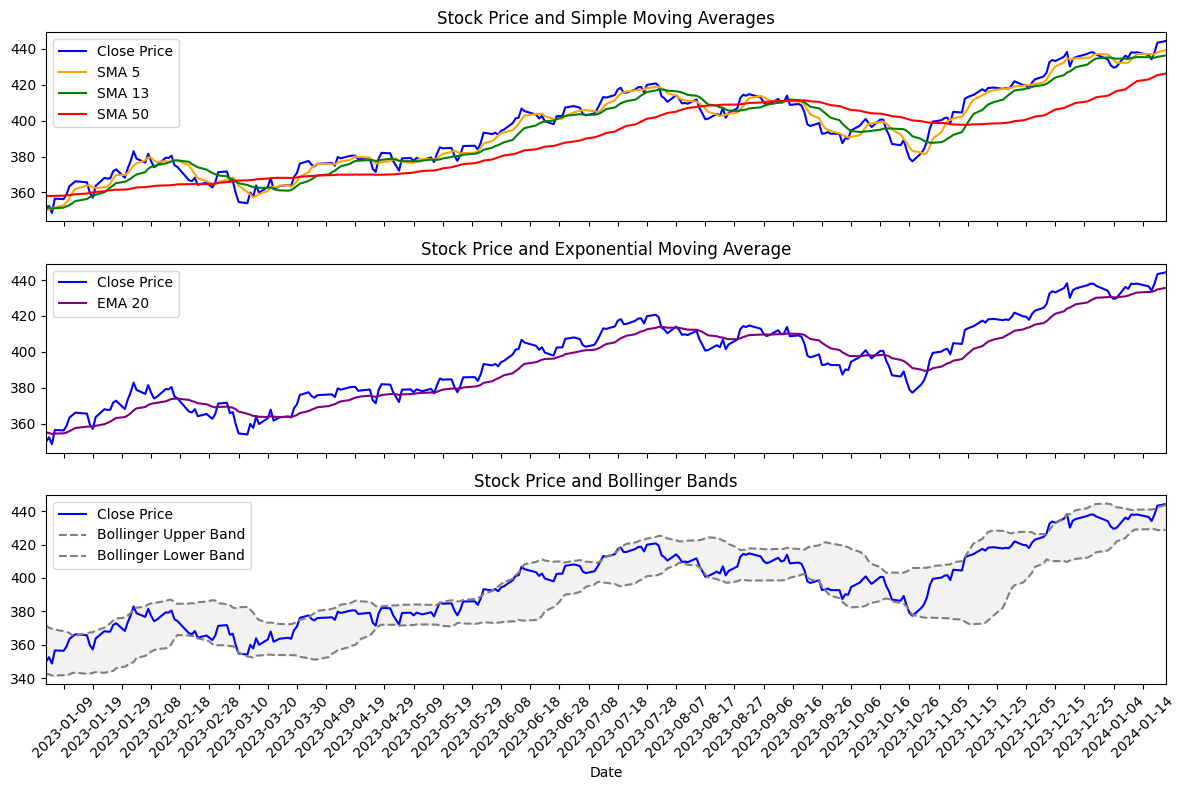

In [215]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Calculate technical indicators and add them as features
def SMA(data, period=30, column='Close'):
    return data[column].rolling(window=period).mean()

def EMA(data, period=20, column='Close'):
    return data[column].ewm(span=period, adjust=False).mean()

def Bollinger_Bands(data, period=20, column='Close'):
    sma = SMA(data, period, column=column)
    std_dev = data[column].rolling(window=period).std()
    data['Bollinger_Upper'] = sma + (std_dev * 2)
    data['Bollinger_Lower'] = sma - (std_dev * 2)
    return data

def RSI(data, period=14, column='Close'):
    delta = data[column].diff(1)
    delta = delta.dropna()

    up = delta.copy()
    down = delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    data['up'] = up
    data['down'] = down

    AVG_Gain = SMA(data, period, column='up')
    AVG_Loss = abs(SMA(data, period, column='down'))
    RS = AVG_Gain / AVG_Loss

    RSI = 100.0 - (100.0 / (1.0 + RS))

    return RSI


df['SMA_5'] = SMA(df, period=5)
df['SMA_13'] = SMA(df, period=13)
df['SMA_50'] = SMA(df, period=50)
df['EMA'] = EMA(df, period=20)
Bollinger_Bands(df)
df['RSI'] = RSI(df)

df = df.iloc[50:]
# print(df.head())


# Now plot the technical indicators for the past 3 months
def plot_stock_with_indicators(data, start_date):
    """
    Plot stock prices with technical indicators.

    :param data: DataFrame with stock data and technical indicators.
    :param start_date: The starting date for the plot (format: 'YYYY-MM-DD').
    """
    # Filter data from the start date
    data['Date'] = pd.to_datetime(data['Date'])
    filtered_data = data[data['Date'] >= pd.to_datetime(start_date)]

    # Set 'Date' as the index of the filtered data
    filtered_data.set_index('Date', inplace=True)
    # print(filtered_data)
    # Create subplots
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 8), sharex=True)

    # Define date formatting for x-axis
    date_format = mdates.DateFormatter('%Y-%m-%d')
    date_locator = mdates.DayLocator(interval=10)  # Adjust interval as needed

    # Plot closing price and SMAs
    axes[0].xaxis.set_major_formatter(date_format)
    axes[0].xaxis.set_major_locator(date_locator)
    axes[0].plot(filtered_data['Close'], label='Close Price', color='blue')
    axes[0].plot(filtered_data['SMA_5'], label='SMA 5', color='orange')
    axes[0].plot(filtered_data['SMA_13'], label='SMA 13', color='green')
    axes[0].plot(filtered_data['SMA_50'], label='SMA 50', color='red')
    axes[0].legend(loc='upper left')
    axes[0].set_title('Stock Price and Simple Moving Averages')

    # Plot EMA
    axes[1].xaxis.set_major_formatter(date_format)
    axes[1].xaxis.set_major_locator(date_locator)
    axes[1].plot(filtered_data['Close'], label='Close Price', color='blue')
    axes[1].plot(filtered_data['EMA'], label='EMA 20', color='purple')
    axes[1].legend(loc='upper left')
    axes[1].set_title('Stock Price and Exponential Moving Average')

    # Plot Bollinger Bands
    axes[2].xaxis.set_major_formatter(date_format)
    axes[2].xaxis.set_major_locator(date_locator)
    axes[2].plot(filtered_data['Close'], label='Close Price', color='blue')
    axes[2].plot(filtered_data['Bollinger_Upper'], label='Bollinger Upper Band', linestyle='--', color='grey')
    axes[2].plot(filtered_data['Bollinger_Lower'], label='Bollinger Lower Band', linestyle='--', color='grey')
    axes[2].fill_between(filtered_data.index, filtered_data['Bollinger_Upper'], filtered_data['Bollinger_Lower'], color='grey', alpha=0.1)
    axes[2].legend(loc='upper left')
    axes[2].set_title('Stock Price and Bollinger Bands')

    # Set x-axis limits
    axes[0].set_xlim(filtered_data.index.min(), filtered_data.index.max())
    axes[1].set_xlim(filtered_data.index.min(), filtered_data.index.max())
    axes[2].set_xlim(filtered_data.index.min(), filtered_data.index.max())

    # Rotate date labels for better readability
    for ax in axes:
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

    # Set common labels
    plt.xlabel('Date')
    plt.tight_layout()
    plt.show()
    # print(filtered_data.loc['2023-10-22':'2023-10-31'])

# Example usage
 
plot_stock_with_indicators(df, start_date='2023-01-01')
 

# Data Scale, Split and Feature Creation

In [216]:
from sklearn.preprocessing import StandardScaler

# # Assuming df is sorted in chronological order
split_ratio = 0.8
split_index = int(len(df) * split_ratio)

train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

# List of columns to scale
columns_to_scale = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_5', 'SMA_13', 'SMA_50', 'EMA', 'Bollinger_Upper', 'Bollinger_Lower', 'RSI']

# Initialize a scaler for each column
scalers = {col: StandardScaler() for col in columns_to_scale}

# Scale the training data
train_scaled = train_df.copy()
for col in columns_to_scale:
    train_scaled[col] = scalers[col].fit_transform(train_scaled[[col]])

# # Scale the test data using the same scalers
test_scaled = test_df.copy()
for col in columns_to_scale:
    test_scaled[col] = scalers[col].transform(test_scaled[[col]])

# print(train_scaled.head())

print(test_scaled.head())


           Date      Open      High       Low     Close   Adj Close    Volume  \
2701 2021-06-03  2.710194  2.711092  2.720382  2.722712  368.843964  0.657193   
2702 2021-06-04  2.750062  2.751512  2.782052  2.775420  372.187469  0.280698   
2703 2021-06-07  2.775886  2.749859  2.789495  2.770436  371.871307  0.217777   
2704 2021-06-08  2.783135  2.755719  2.777191  2.771342  371.928802  0.161517   
2705 2021-06-09  2.784343  2.756471  2.791925  2.762129  371.344452  0.448490   

         SMA_5    SMA_13    SMA_50       EMA  Bollinger_Upper  \
2701  2.744147  2.729311  2.749151  2.744693         2.659130   
2702  2.753595  2.736882  2.758819  2.752305         2.666556   
2703  2.759772  2.747930  2.767759  2.758712         2.666935   
2704  2.767039  2.760217  2.775293  2.764596         2.674607   
2705  2.770491  2.767075  2.782706  2.769032         2.681726   

      Bollinger_Lower        up      down       RSI  
2701         2.801707  0.000000 -1.470001  0.577346  
2702         2

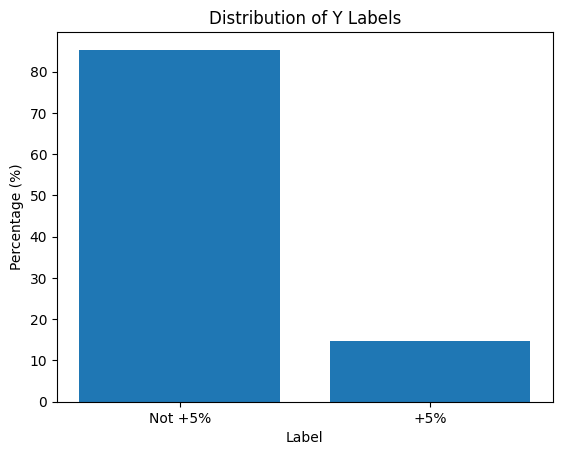

In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def create_features_labels(df, train_period=90, prediction_period=14):
    feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_5', 'SMA_13', 'SMA_50', 'EMA', 'Bollinger_Upper', 'Bollinger_Lower', 'RSI']
    X = []
    Y = []

    # Convert DataFrame to numpy array for efficient processing
    df_values = df[feature_columns].values
    close_prices = df['Close'].values  # Close prices for label calculation

    for start in range(len(df) - train_period - prediction_period):
        end = start + train_period

        # Extract features using numpy
        window_features = df_values[start:end].flatten()
        X.append(window_features)

        # Efficient label calculation
        future_end = end + prediction_period
        max_close = np.max(close_prices[end:future_end])
        start_close = close_prices[end - 1]

        max_pct_change = (max_close - start_close) / start_close
        label = 1 if max_pct_change > 0.15 else 0
        Y.append(label)

    return np.array(X), np.array(Y)

# Example usage
# df = pd.read_csv('path_to_your_file.csv')
# train_scaled = df.copy()  # Assuming df is your DataFrame after scaling
X, Y = create_features_labels(train_scaled)

# Plot the distribution of y label
labels, counts = np.unique(Y, return_counts=True)
percentages = (counts / sum(counts)) * 100

plt.bar(labels, percentages, tick_label=["Not +5%", "+5%"])
plt.xlabel('Label')
plt.ylabel('Percentage (%)')
plt.title('Distribution of Y Labels')
plt.show()


# Logistic Regression

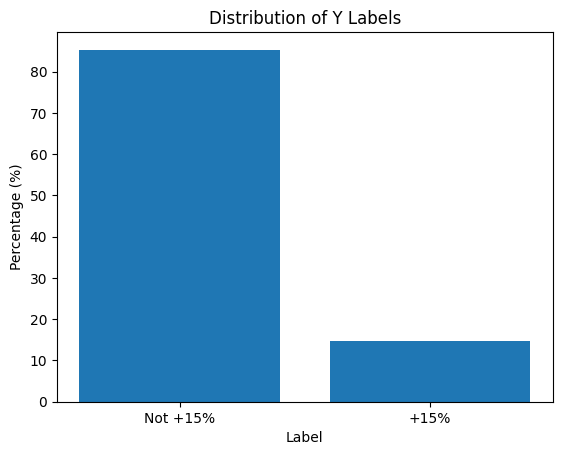

(2547, 1080) (559, 1080)
(2547,) (559,)


In [219]:
X, Y = create_features_labels(train_scaled, train_period=90, prediction_period=14)
X_test, Y_test = create_features_labels(test_scaled, train_period=90, prediction_period=14)

# Plot the distribution of y label
labels, counts = np.unique(Y, return_counts=True)
percentages = (counts / sum(counts)) * 100

plt.bar(labels, percentages, tick_label=["Not +15%", "+15%"])
plt.xlabel('Label')
plt.ylabel('Percentage (%)')
plt.title('Distribution of Y Labels')
plt.show()
print(X.shape, X_test.shape)

print(Y.shape, Y_test.shape)


In [234]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# train_df, test_df = train_test_split(df_scaled, test_size=0.2, random_state=42)

# Generate features and labels
X, Y = create_features_labels(train_scaled, train_period=30, prediction_period=7)

# Create a logistic regression model
Logistic_model = LogisticRegression(max_iter=1000)

# Train the model
Logistic_model.fit(X, Y)

# Evaluate the model
X_test, Y_test = create_features_labels(test_scaled, train_period=30, prediction_period=7)

predictions_test = Logistic_model.predict(X_test)
print("Cross-Validation Classification Report:")
print(classification_report(Y_test, predictions_test))

print(test_scaled.shape, Y_test.shape)

Cross-Validation Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.79      0.88       614
           1       0.05      0.50      0.08        12

    accuracy                           0.79       626
   macro avg       0.52      0.65      0.48       626
weighted avg       0.97      0.79      0.86       626

(663, 16) (626,)


(663, 16)
(626,)


/var/folders/jb/x5q2pkmx3p5_x479n8vzms6c0000gn/T/ipykernel_20373/987865811.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Date'] = pd.to_datetime(test_df['Date'])
/var/folders/jb/x5q2pkmx3p5_x479n8vzms6c0000gn/T/ipykernel_20373/987865811.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aligned_test_df['Prediction'] = Y_test


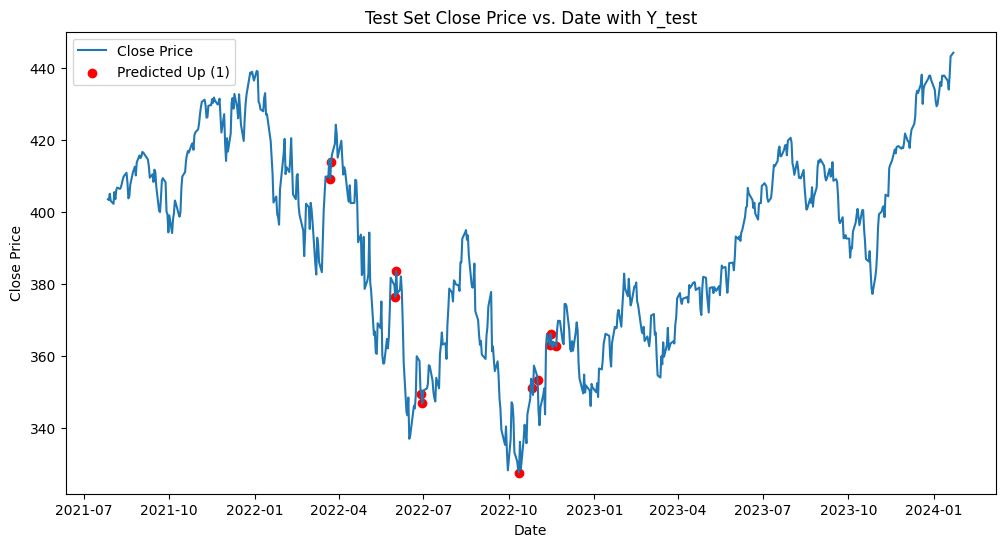

In [225]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_test_with_price(test_df, Y_test, train_period=30, prediction_period=7):
    """
    Plot the stock's closing price for the test set and highlight the days where Y_test is 1.

    :param test_df: DataFrame with test set stock data.
    :param Y_test: The actual labels for the test set.
    :param train_period: Number of days used for training period.
    :param prediction_period: Number of days ahead to predict.
    """
    # Ensure 'Date' column is datetime
    test_df['Date'] = pd.to_datetime(test_df['Date'])
    print(test_df.shape)
    print(Y_test.shape)
    # Align the length of test_df with Y_test
    # Since create_features_labels function uses a sliding window, align the test_df accordingly
    aligned_test_df = test_df.iloc[-len(Y_test):]
    aligned_test_df['Prediction'] = Y_test

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(aligned_test_df['Date'], aligned_test_df['Close'], label='Close Price')

    # Highlight where Y_test is 1
    predicted_up = aligned_test_df[aligned_test_df['Prediction'] == 1]
    plt.scatter(predicted_up['Date'], predicted_up['Close'], color='red', label='Predicted Up (1)')

    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title('Test Set Close Price vs. Date with Y_test')
    plt.legend()
    plt.show()

# Example usage
plot_test_with_price(test_df, Y_test)


# Neural Network

In [230]:
X_train, Y_train = create_features_labels(train_scaled, train_period=90, prediction_period=14)
X_test, Y_test   = create_features_labels(test_scaled,  train_period=90, prediction_period=14)


(2547, 1080) (2547,)
[[-1.44412808 -1.43897214 -1.43583553 ... -1.28287937 -1.28590062
  -0.56151837]
 [-1.43778541 -1.43867155 -1.43644314 ... -1.28028128 -1.28653983
   0.17019224]
 [-1.43899357 -1.4407752  -1.4434304  ... -1.28267927 -1.2853261
  -0.04505419]
 ...
 [ 2.09797177  2.07488576  2.0849947  ...  2.61915644  2.83392641
   0.22799098]
 [ 2.07758441  2.06196353  2.0956277  ...  2.61877635  2.84350258
   0.10281265]
 [ 2.07063776  2.08390152  2.09046325 ...  2.61742025  2.8471815
  -0.61238361]]


In [233]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score
from tensorflow.keras.regularizers import l2
import pandas as pd
import numpy as np

# train_df, test_df = train_test_split(df_scaled, test_size=0.2, random_state=42)

# Generate features and labels
X_train, Y_train = create_features_labels(train_scaled, train_period=30, prediction_period=14)
X_test, Y_test   = create_features_labels(test_scaled,  train_period=30, prediction_period=14)

# Define the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['Precision', 'Recall'])

# Train the model
history = model.fit(X_train, Y_train, epochs=100, validation_split=0.2, batch_size=32, verbose=2)

# Evaluate the model on training data
train_metrics = model.evaluate(X_train, Y_train)
train_precision = train_metrics[1]
train_recall = train_metrics[2]
train_f1 = 2 * (train_precision * train_recall) / (train_precision + train_recall)

# Evaluate the model on test dpata
epsilon = 1e-7

test_metrics = model.evaluate(X_test, Y_test, verbose=0)
test_precision = test_metrics[1]
test_recall = test_metrics[2]
test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall+epsilon)

# Summary
print("\nModel Performance Summary:")
print("Training: ")
print(f"  - Precision: {train_precision:.4f}")
print(f"  - Recall: {train_recall:.4f}")
print(f"  - F1 Score: {train_f1:.4f}")

print("Testing: ")
print(f"  - Precision: {test_precision:.4f}")
print(f"  - Recall: {test_recall:.4f}")
print(f"  - F1 Score: {test_f1:.4f}")


Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_120 (Dense)           (None, 64)                23104     
                                                                 
 dropout_97 (Dropout)        (None, 64)                0         
                                                                 
 dense_121 (Dense)           (None, 64)                4160      
                                                                 
 dropout_98 (Dropout)        (None, 64)                0         
                                                                 
 dense_122 (Dense)           (None, 64)                4160      
                                                                 
 dropout_99 (Dropout)        (None, 64)                0         
                                                                 
 dense_123 (Dense)           (None, 32)              

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Convert 'Date' column to datetime if it's not already
df['Date'] = pd.to_datetime(df['Date'])

# Filter the data for the last three months
three_months_ago = pd.to_datetime("today") - pd.DateOffset(months=3)
recent_df = df[df['Date'] >= three_months_ago]

# Generate features for the recent data
X_recent, _ = create_features_labels(recent_df)

# Make predictions for the recent data
recent_predictions = model.predict(X_recent).round().flatten()

# Adjust the trimmed_df to match the length of recent_predictions
# Since recent_predictions is shorter, trim the beginning of recent_df
trimmed_df = recent_df.iloc[-len(recent_predictions):]

# Add predictions to the trimmed DataFrame
trimmed_df['Prediction'] = recent_predictions

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(trimmed_df['Date'], trimmed_df['Close'], label='Close Price')

# Highlight where prediction is 1
predicted_up = trimmed_df[trimmed_df['Prediction'] == 1]
plt.scatter(predicted_up['Date'], predicted_up['Close'], color='red', label='Predicted Up (1)')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price vs. Date with NN Predictions for the Last 3 Months')
plt.legend()
plt.show()


ValueError: Expected input data to be non-empty.

# RNN with Gated Recurrent Units

### GRU structure

(2577, 60, 12)


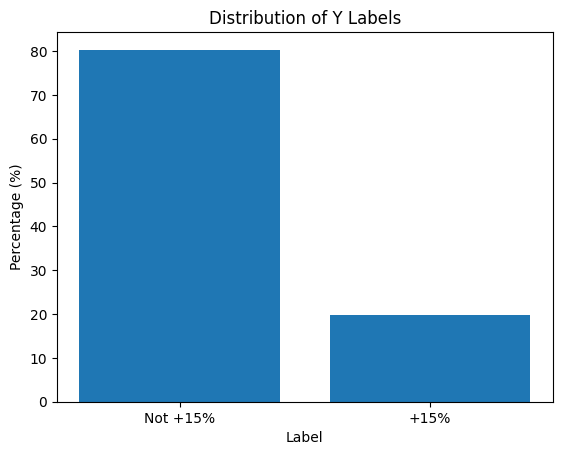

In [264]:
import pandas as pd
import numpy as np

def create_features_labels_for_rnn(df, train_period=60, prediction_period=14):
    feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_5', 'SMA_13', 'SMA_50', 'EMA', 'Bollinger_Upper', 'Bollinger_Lower', 'RSI']
    X = []
    Y = []

    for start in range(len(df) - train_period - prediction_period):
        end = start + train_period

        # Extract the 90-day window for features
        window_df = df.iloc[start:end]
        window_features = window_df[feature_columns].values  # Convert to numpy array for efficiency

        X.append(window_features)

        # Calculate the label based on the next 14 days
        future_end = end + prediction_period
        max_close = df['Close'].iloc[end:future_end].max()
        start_close = df['Close'].iloc[end - 1]

        max_pct_change = (max_close - start_close) / start_close
        label = 1 if max_pct_change > 0.10 else 0

        Y.append(label)

    return np.array(X), np.array(Y)

# Example usage
# df = pd.read_csv('path_to_your_file.csv')
X_train, Y_train = create_features_labels_for_rnn(train_scaled)
X_test, Y_test = create_features_labels_for_rnn(test_scaled)

print(X_train.shape)
# Plot the distribution of y label
labels, counts = np.unique(Y_test, return_counts=True)
percentages = (counts / sum(counts)) * 100

plt.bar(labels, percentages, tick_label=["Not +15%", "+15%"])
plt.xlabel('Label')
plt.ylabel('Percentage (%)')
plt.title('Distribution of Y Labels')
plt.show()

In [272]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.utils.class_weight import compute_class_weight

# Number of features per day in your dataset
num_samples, window_size, num_features = X_train.shape

# Define the GRU model
model = Sequential([
    GRU(32, return_sequences=True, kernel_regularizer=l2(0.01), input_shape=(window_size, num_features)),
    Dropout(0.5),
    GRU(32, return_sequences=False, kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Using sigmoid for binary classification
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(Y_train), y=Y_train)

# Convert class_weights to a dictionary to pass to fit method
class_weight_dict = dict(enumerate(class_weights))

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, Y_train, epochs=100, validation_split=0.2, class_weight=class_weight_dict, batch_size=32, verbose=2)

# Evaluate the model

test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


# You can also include code for plotting training history or making predictions as needed


Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_20 (GRU)                (None, 60, 32)            4416      
                                                                 
 dropout_121 (Dropout)       (None, 60, 32)            0         
                                                                 
 gru_21 (GRU)                (None, 32)                6336      
                                                                 
 dropout_122 (Dropout)       (None, 32)                0         
                                                                 
 dense_145 (Dense)           (None, 32)                1056      
                                                                 
 dense_146 (Dense)           (None, 1)                 33        
                                                                 
Total params: 11841 (46.25 KB)
Trainable params: 1184

In [277]:
print(train_scaled.shape, Y_train.shape)

(2651, 16) (2577,)


In [279]:
import matplotlib.pyplot as plt
import pandas as pd
# Filter the DataFrame for the year 2022
start_date = "2023-01-01"
end_date = "2023-12-31"
mask = (test_scaled['Date'] >= start_date) & (test_scaled['Date'] <= end_date)
df_2023 = test_scaled.loc[mask]
_, Y_2023 = create_features_labels_for_rnn(df_2023)
s
print(df_2023.shape, Y_2023.shape)
# Align the length of tesst_df with Y_test
aligned_test_df = df_2023.iloc[-len(Y_test):]

# Add Y_test labels to the DataFrame
aligned_test_df['Prediction'] = Y_2023

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(aligned_test_df['Date'], aligned_test_df['Close'], label='Close Price')

# Highlight where Y_test is 1
predicted_up = aligned_test_df[aligned_test_df['Prediction'] == 1]
plt.scatter(predicted_up['Date'], predicted_up['Close'], color='red', label='Predicted Up (1)')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Test Set Close Price vs. Date with Y_test')
plt.legend()
plt.show()

# Example usage
# plot_y_test_with_price(train_scaled, Y_train)


(250, 16) (176,)


ValueError: Length of values (176) does not match length of index (250)

In [274]:
Predict_test = model.predict(X_test)
print(Predict_test)

19/19 [==============================] - 0s 3ms/step
[[0.01328338]
 [0.01332519]
 [0.01328752]
 [0.01330113]
 [0.0133613 ]
 [0.01330697]
 [0.01324632]
 [0.0132245 ]
 [0.01320524]
 [0.01315406]
 [0.01315591]
 [0.01329335]
 [0.01350252]
 [0.01364327]
 [0.01369405]
 [0.013852  ]
 [0.01503316]
 [0.01624305]
 [0.01669177]
 [0.01656808]
 [0.01618563]
 [0.01581389]
 [0.0159824 ]
 [0.01627483]
 [0.01683773]
 [0.01753123]
 [0.01810107]
 [0.01819643]
 [0.0180536 ]
 [0.01766852]
 [0.01706133]
 [0.01651084]
 [0.01624668]
 [0.01639303]
 [0.01632445]
 [0.01597914]
 [0.01554922]
 [0.01508899]
 [0.01465984]
 [0.01424877]
 [0.01393987]
 [0.01365384]
 [0.01338944]
 [0.01318333]
 [0.01306525]
 [0.01301336]
 [0.0129569 ]
 [0.01286423]
 [0.0127559 ]
 [0.01267786]
 [0.01266486]
 [0.01266849]
 [0.01264264]
 [0.01271447]
 [0.01286197]
 [0.01289637]
 [0.01287993]
 [0.01284387]
 [0.01278542]
 [0.01279892]
 [0.01286507]
 [0.01295917]
 [0.01315874]
 [0.01335042]
 [0.01371688]
 [0.01420288]
 [0.01474125]
 [0.01541

2/2 [==============================] - 0s 4ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


/var/folders/jb/x5q2pkmx3p5_x479n8vzms6c0000gn/T/ipykernel_20373/3241013368.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_df['Prediction'] = recent_predictions


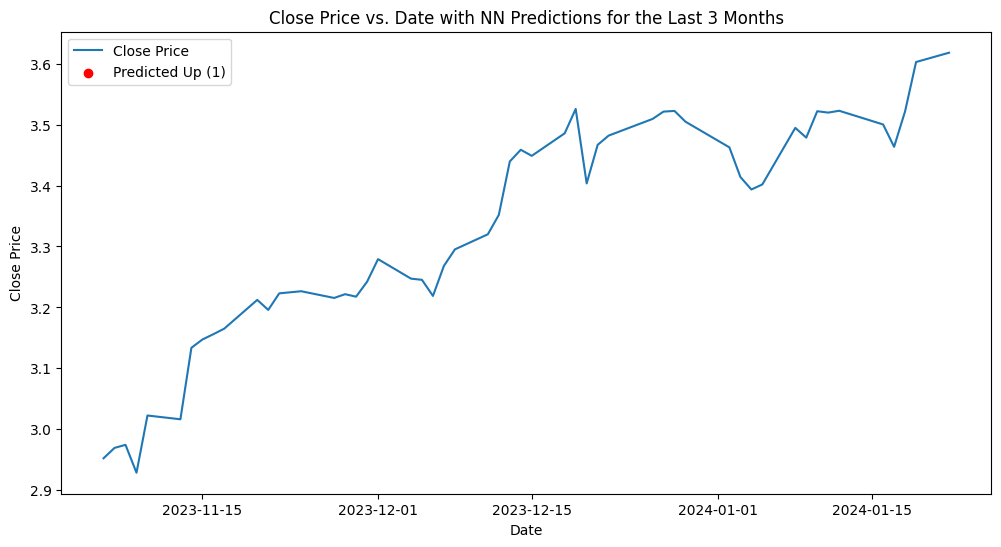

In [273]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming df is your original DataFrame with stock data
# Convert 'Date' column to datetime if it's not already
test_scaled['Date'] = pd.to_datetime(test_scaled['Date'])

# Filter the data for the last three months
three_months_ago = pd.to_datetime("today") - pd.DateOffset(months=6)
recent_df = test_scaled[test_scaled['Date'] >= three_months_ago]

# Assuming create_features_labels_for_rnn is your modified function for the GRU model
# Generate features for the recent data
X_recent, _ = create_features_labels_for_rnn(recent_df, train_period=60, prediction_period=14)

# Make predictions for the recent data
# Flatten the predictions and round them to get binary values
recent_predictions = model.predict(X_recent).flatten().round()
print(recent_predictions)
# Since each prediction is based on the last 90 days of data,
# we need to align the length of recent_df with the length of recent_predictions
# Trim the beginning of recent_df to match the length of recent_predictions
trimmed_df = recent_df.iloc[-len(recent_predictions):]

# Add predictions to the trimmed DataFrame
trimmed_df['Prediction'] = recent_predictions

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(trimmed_df['Date'], trimmed_df['Close'], label='Close Price')

# Highlight where prediction is 1
predicted_up = trimmed_df[trimmed_df['Prediction'] == 1]
plt.scatter(predicted_up['Date'], predicted_up['Close'], color='red', label='Predicted Up (1)')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price vs. Date with NN Predictions for the Last 3 Months')
plt.legend()
plt.show()
